<a href="https://colab.research.google.com/github/Hernan4444/diplomado-sistemas-recomendadores/blob/master/Diplomado_Alumno_2019_Sistemas_Recomendadores_3_Content_Based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TAREA 1: SISTEMAS RECOMENDADORES

**Integrantes**: Martin Alamos, Franco Mendez

# Pregunta 1

Grafique la distribución de usuarios con número de interacciones, identifique los 5 usuarios más
activos en el dataset de WikiMedia Commons. Comente la forma de la distribución y qué por-
centaje de las interacciones han sido hechas por estos 5 usuarios.


In [31]:
import pandas as pd
import numpy as np
import pyreclab
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import math
import time
import implicit

In [1]:
views = {} # user : numer_of_interactions
image_views = {} # image: number_of_interactions

fo = open("files/training.csv", "r")
fo.readline()
for line in fo.readlines():
    user, image, time = line.rstrip().split(",")
    if user in views:
        views[user] += 1
    else:
        views[user] = 1

    if image in image_views:
        image_views[image] +=1
    else:
        image_views[image] = 1
fo.close()

Hacemos los correspondinetes diccionarios con numero de iteraciones

In [3]:
user_interaction = {} # number_of_interactions : amount_of_users
for user in views:
    if views[user] in user_interaction:
        user_interaction[views[user]] += 1
    else:
        user_interaction[views[user]] = 1

image_interaction = {} # number_of_interactions : amount_of_images
for image in image_views:
    if image_views[image] in image_interaction:
        image_interaction[image_views[image]] += 1
    else:
        image_interaction[image_views[image]] = 1

Tomamos el top 5 de imagenes y usuarios segun interacciones

In [16]:
# get top
top_five_users = [] # user1, user2, ...
counter = 0
for key, value in sorted(views.items(), key=lambda kv: kv[1], reverse=True):
    top_five_users.append(key)
    counter += 1
    if counter > 4: break

top_five_image = [] # user1, user2, ...
counter = 0
for key, value in sorted(image_views.items(), key=lambda kv: kv[1], reverse=True):
    top_five_image.append(key)
    counter += 1
    if counter > 4: break
# finish get top 5
print("los 5 usuarios mas activos son :", top_five_users)
print("las 5 imagenes mas vistas son", top_five_image)

los 5 usuarios mas activos son : ['2524', '4605', '2133', '5907', '5607']
las 5 imagenes mas vistas son ['201707149', '201812099', '201804142', '201901175', '201204203']


Calculamos las estadisticas

In [8]:
total_number_of_interactions = sum(views[u] for u in views)
number_of_different_users = len(views)
number_of_different_images = len(image_views)
mean_image_per_user = sum(views[u] for u in views) / number_of_different_users
de_image_per_user = math.sqrt((sum((views[u] - mean_image_per_user)**2 for u in views))/number_of_different_users)
mean_user_per_image = sum(image_views[i] for i in image_views) / number_of_different_images
de_user_per_image = math.sqrt((sum((image_views[i] - mean_user_per_image)**2 for i in image_views))/number_of_different_images)
density = total_number_of_interactions / (number_of_different_users * number_of_different_images)
sparsity = 1 - density

print("stats:")
print("number of users:", number_of_different_users)
print("number of images:", number_of_different_images)
print("mean_image_per_user:", mean_image_per_user)
print("de_image_per_user:", de_image_per_user)
print("mean_user_per_image:", mean_user_per_image)
print("de_user_per_image:", de_user_per_image)
print("density:", density)
print("sparsity:", sparsity)

stats:
number of users: 1079
number of images: 9630
mean_image_per_user: 89.41612604263207
de_image_per_user: 260.53834648700354
mean_user_per_image: 10.018691588785046
de_user_per_image: 4.35659507116784
density: 0.009285163659671036
sparsity: 0.990714836340329


Actualizamos datos para ser graficados

In [12]:
# lets graph!
user_graph_data = [] # (number_of_interactions, number_of_users rango de 3)
for k in user_interaction:
    user_graph_data.append((k, user_interaction[k]))
user_graph_data = sorted(user_graph_data)

image_graph_data = []
for k in image_interaction:
    image_graph_data.append((k, image_interaction[k]))
image_graph_data = sorted(image_graph_data)

# aca agrupamos la info para que no sea tan grande
new_graph_data = [] # ('0-3', 74), ('4-7', 95)
x_name = ''
count = 0
counter = 0
for x, y in user_graph_data:
    counter += y
    if count == 0:
        x_name = str(x) + '-'
    if count == 3:
        x_name += str(x)
        new_graph_data.append((x_name, counter))
        count = -1
        counter = 0
    count += 1

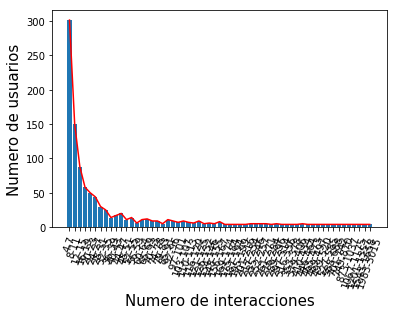

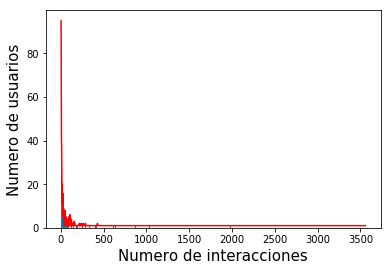

los 5 usuarios mas activos son : ['2524', '4605', '2133', '5907', '5607']


In [14]:
plt.bar([i[0] for i in new_graph_data], [j[1] for j in new_graph_data])
plt.xlabel('Numero de interacciones', fontsize=15)
plt.ylabel('Numero de usuarios', fontsize=15)
plt.xticks([i[0] for i in new_graph_data], [i[0] for i in new_graph_data], rotation=70)
plt.plot([i[0] for i in new_graph_data], [j[1] for j in new_graph_data], 'r-')
plt.show()

# simple graph
plt.bar([i[0] for i in user_graph_data], [j[1] for j in user_graph_data])
plt.xlabel('Numero de interacciones', fontsize=15)
plt.ylabel('Numero de usuarios', fontsize=15)
plt.plot([i[0] for i in user_graph_data], [j[1] for j in user_graph_data], 'r-')
plt.show()

In [17]:
total_interactions = 0
interactions_made_by_top_5_users = 0
interactions_in_top_5_images = 0

for user in views:
    total_interactions += views[user]
    if user in top_five_users:
        interactions_made_by_top_5_users += views[user]
print("total_interactions: ", total_interactions)
print("made by top 5 users", interactions_made_by_top_5_users)
percent_user = 100 * interactions_made_by_top_5_users / total_interactions
print("percent made by top 5 users", percent_user)

for image in image_views:
    if image in top_five_image:
        interactions_in_top_5_images += image_views[image]
percent_imaage = 100 * interactions_in_top_5_images / total_interactions
print("percent of image", percent_imaage)

print("made by in top 5 images", interactions_in_top_5_images)

total_interactions:  96480
made by top 5 users 13477
percent made by top 5 users 13.968698175787727
percent of image 0.16065505804311775
made by in top 5 images 155


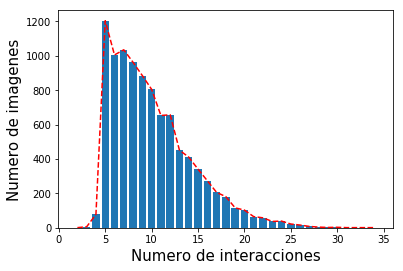

los 5 imagenes mas vistas son : ['201707149', '201812099', '201804142', '201901175', '201204203']


In [18]:
plt.xlabel('Numero de interacciones', fontsize=15)
plt.ylabel('Numero de imagenes', fontsize=15)
plt.bar([i[0] for i in image_graph_data], [j[1] for j in image_graph_data])
plt.plot([i[0] for i in image_graph_data], [j[1] for j in image_graph_data], 'r--')
plt.show()
print("los 5 imagenes mas vistas son :", top_five_image)

# Pregunta 2

Importamos la informacion requerida

In [44]:
import metrics

metrics = metrics.Metrics()

TRAIN_FILE = 'data/new_training_set.csv'
TEST_FILE = 'data/new_testing_set.csv'

funciones para evaluar el modelo y mostrar recomendaciones

In [23]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in range(len(user_items)): # para cada user_id en el training
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    user_item_test_list = [items_ids[i] for i in user_items_test[user_ids_inv[u]]] # lista con las peliculas que vio en el test
    rel_vector = [np.isin(user_item_test_list, rec, assume_unique=True).astype(int)]
    mean_map += metrics.mean_average_precision(rel_vector)
    mean_ndcg += metrics.ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)

  return mean_map, mean_ndcg

def show_recommendations(model, user, n):
  recommendations = [items_ids_inv[t[0]] for t in model.recommend(user, user_item_matrix, n)]
  return recommendations

def show_similar_item(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return sim_items

In [24]:
df_train = pd.read_csv(TRAIN_FILE, names=['userid', 'itemid', 'timestamp'])
df_test = pd.read_csv(TEST_FILE, names=['userid', 'itemid', 'timestamp'])

# TEST USER ITEM
user_items_test = {} # {userid: [imageid1, imageid2, ... ]}
for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
    user_items_test[row[1]].append(row[2])

# PROCESAMIENTO DE LOS DATOS A FORMATO SPARSE
user_items = {} # TRAIN - {userid: [imageid1, imageid2, ... ]}
itemset = set() # {imageid1, imageid2, imageid3, ... }

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

# agregamos aquellas imagenes que no estan en el df_test
for row in df_test.itertuples():
    itemset.add(row[2])

In [45]:
itemset = np.sort(list(itemset)) # todos los items ordenados en un set
userset = np.sort(list(user_items.keys())) # todos los users ordenados en un set

user_ids = {key: i for i, key in enumerate(userset)} # user_id: numero_file_en_la_matriz
user_ids_inv = {i: key for i, key in enumerate(userset)} # numero_file_en_la_matriz: user_id:

items_ids = {key: i for i, key in enumerate(itemset)} # item_id: numero_columna_en_la_matriz
items_ids_inv = {i: key for i, key in enumerate(itemset)} # numero_columna_en_la_matriz: item_id

sparse_matrix = np.zeros((len(user_items), len(itemset))) # matriz de nxm llena de 0s

for i in range(len(user_items)):
    sparse_matrix[i] = np.isin(itemset, user_items[user_ids_inv[i]], assume_unique=True).astype(int)

matrix = sparse.csr_matrix(sparse_matrix.T)
user_item_matrix = matrix.T.tocsr()
# FIN PROCESAMIENTO DE LOS DATOS A FORMATO SPARSE

Los hiperámetros a utilizar son los siguientes

In [46]:
# tiempos e hiperparametros
test_factors = [50, 100, 200, 500, 1000]
test_iterations = [15, 20, 60, 140, 200]
test_regulazation = [0.01, 0.1, 0.15, 0.2, 0.5]
test_lr = [0.001, 0.01, 0.02, 0.05]

## 2.1 ALS


recomendaciones als factor:  50 [200505072, 200505089, 200601018, 200603023, 200606042]
timepo de entrenamiento als facotr:  50 4.76656436920166



recomendaciones als factor:  100 [200603023, 200603024, 200602011, 200602026, 200512005]
timepo de entrenamiento als facotr:  100 7.691938877105713



recomendaciones als factor:  200 [200505089, 200505060, 200512005, 200504053, 200512013]
timepo de entrenamiento als facotr:  200 9.315412044525146



recomendaciones als factor:  500 [200601033, 200601029, 200601051, 200602031, 200504053]
timepo de entrenamiento als facotr:  500 23.345606327056885



recomendaciones als factor:  1000 [200505020, 200506012, 200601033, 200504053, 200507049]
timepo de entrenamiento als facotr:  1000 65.51031804084778
maprec:  [0.050873904194541616, 0.0807362774472456, 0.09249732519135304, 0.09856276969466565, 0.08564198035067544]
ndcg:  [0.0871177015755329, 0.12604263206672844, 0.13253012048192772, 0.1417979610750695, 0.12233549582947173]


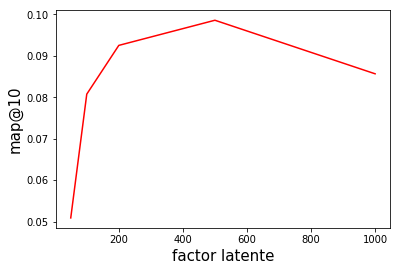

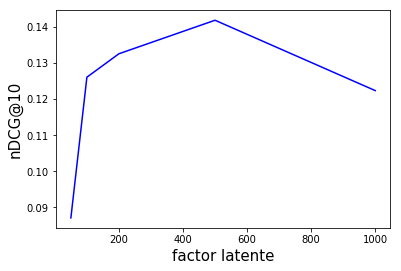

In [32]:
def graph_als_test_factors():
    maprec_results = []
    ndcg_results = []
    for f in test_factors:
        my_time = time.time()
        # iterations default number is 15
        model_als = implicit.als.AlternatingLeastSquares(factors=f)
        model_als.fit(matrix)
        maprec, ndcg = evaluate_model(model_als, n=10)
        maprec_results.append(maprec)
        ndcg_results.append(ndcg)
        recommendations = show_recommendations(model_als, 0, 5)
        print("recomendaciones als factor: ", f, recommendations)
        my_time = time.time() - my_time
        print("timepo de entrenamiento als facotr: ",f, my_time)

    print("maprec: ", maprec_results)
    print("ndcg: ", ndcg_results)

    plt.plot(test_factors, maprec_results, 'r-')
    plt.xlabel('factor latente', fontsize=15)
    plt.ylabel('map@10', fontsize=15)
    plt.show()

    plt.plot(test_factors, ndcg_results, 'b-')
    plt.xlabel('factor latente', fontsize=15)
    plt.ylabel('nDCG@10', fontsize=15)
    plt.show()

graph_als_test_factors()


recomendaciones:  15 : [200603023, 200603024, 200602011, 200602026, 200602003]
timepo:  15 : 7.891480207443237



recomendaciones:  20 : [200603023, 200603024, 200602011, 200602026, 200602003]
timepo:  20 : 9.084436655044556



recomendaciones:  60 : [200603023, 200603024, 200602011, 200602026, 200602003]
timepo:  60 : 21.509495735168457



recomendaciones:  140 : [200603023, 200603024, 200602011, 200602026, 200602003]
timepo:  140 : 47.616093158721924



recomendaciones:  200 : [200603023, 200603024, 200602011, 200602026, 200602003]
timepo:  200 : 66.65637588500977
[0.08009022445623526, 0.08136019012752833, 0.07776779587985423, 0.07925350060351076, 0.08056254129508156]
[0.13067655236329936, 0.12974976830398516, 0.12140871177015755, 0.12326227988878591, 0.12418906394810009]


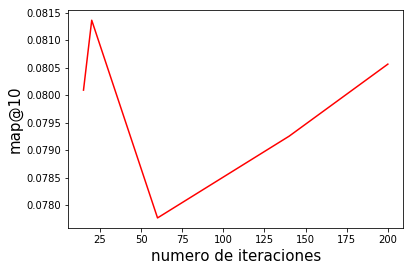

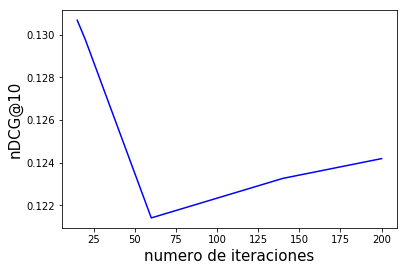

In [33]:
def graph_als_test_iterations():
    maprec_results = []
    ndcg_results = []
    for i in test_iterations:
        # iterations default number is 15
        my_time = time.time()
        model_als = implicit.als.AlternatingLeastSquares(iterations=i)
        model_als.fit(matrix)
        maprec, ndcg = evaluate_model(model_als, n=10)
        maprec_results.append(maprec)
        ndcg_results.append(ndcg)
        recommendations = show_recommendations(model_als, 0, 5)
        print("recomendaciones: ", i,":", recommendations)
        my_time = time.time() - my_time
        print("timepo: ",i,":", my_time)

    print(maprec_results)
    print(ndcg_results)

    plt.plot(test_iterations, maprec_results, 'r-')
    plt.xlabel('numero de iteraciones', fontsize=15)
    plt.ylabel('map@10', fontsize=15)
    plt.show()

    plt.plot(test_iterations, ndcg_results, 'b-')
    plt.xlabel('numero de iteraciones', fontsize=15)
    plt.ylabel('nDCG@10', fontsize=15)
    plt.show()

graph_als_test_iterations()


recomendaciones:  0.01 : [200603023, 200603024, 200602011, 200602026, 200602003]
timepo:  0.01 : 6.056642532348633



recomendaciones:  0.1 : [200603023, 200603024, 200602011, 200602026, 200602003]
timepo:  0.1 : 7.214600563049316



recomendaciones:  0.15 : [200603023, 200603024, 200602011, 200602026, 200602003]
timepo:  0.15 : 7.733816862106323



recomendaciones:  0.2 : [200603023, 200603024, 200602011, 200602026, 200602003]
timepo:  0.2 : 6.5160253047943115



recomendaciones:  0.5 : [200603023, 200603024, 200602011, 200602026, 200602003]
timepo:  0.5 : 6.825636386871338
[0.08104563050305699, 0.08172172369267916, 0.07563428723088299, 0.07981343975855554, 0.08111976105388291]
[0.1278962001853568, 0.13067655236329936, 0.12511584800741427, 0.12418906394810009, 0.12604263206672844]


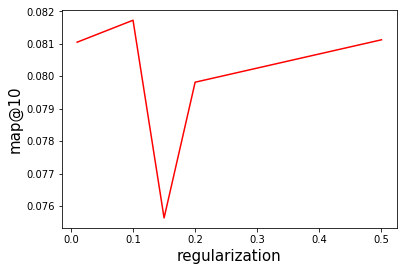

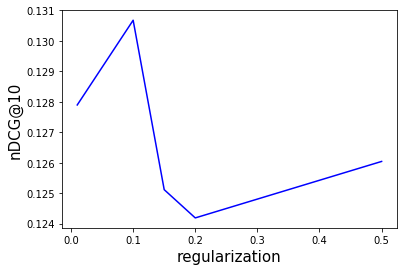

In [34]:
def graph_als_test_regulazation():
    maprec_results = []
    ndcg_results = []
    for r in test_regulazation:
        # iterations default number is 15
        my_time = time.time()
        model_als = implicit.als.AlternatingLeastSquares(regularization=r)
        model_als.fit(matrix)
        maprec, ndcg = evaluate_model(model_als, n=10)
        maprec_results.append(maprec)
        ndcg_results.append(ndcg)
        recommendations = show_recommendations(model_als, 0, 5)
        print("recomendaciones: ", r,":", recommendations)
        my_time = time.time() - my_time
        print("timepo: ",r,":", my_time)

    print(maprec_results)
    print(ndcg_results)

    plt.plot(test_regulazation, maprec_results, 'r-')
    plt.xlabel('regularization', fontsize=15)
    plt.ylabel('map@10', fontsize=15)
    plt.show()

    plt.plot(test_regulazation, ndcg_results, 'b-')
    plt.xlabel('regularization', fontsize=15)
    plt.ylabel('nDCG@10', fontsize=15)
    plt.show()

graph_als_test_regulazation()

## 2.2 BPR


recomendaciones:  50 : [200508079, 200602006, 200607053, 200606163, 200603001]
timepo:  50 : 3.2452003955841064



recomendaciones:  100 : [200602011, 200508088, 200603023, 200605067, 200505072]
timepo:  100 : 4.5726635456085205



recomendaciones:  200 : [200606161, 200602011, 200606042, 200505089, 200602026]
timepo:  200 : 7.197801828384399



recomendaciones:  500 : [200508010, 200510019, 200612002, 200505072, 200512063]
timepo:  500 : 14.877537488937378



recomendaciones:  1000 : [200609052, 200602088, 200602026, 200510072, 200508079]
timepo:  1000 : 25.612460613250732


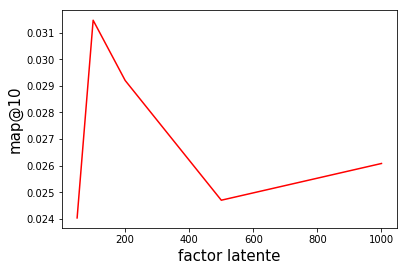

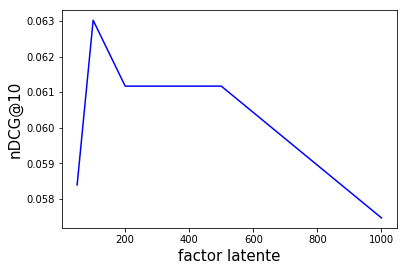

In [35]:
def graph_bpr_test_factors():
    maprec_results = []
    ndcg_results = []
    for f in test_factors:
        my_time = time.time()
        model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f)
        model_bpr.fit(matrix)
        maprec, ndcg = evaluate_model(model_bpr, n=10)
        maprec_results.append(maprec)
        ndcg_results.append(ndcg)
        recommendations = show_recommendations(model_bpr, 0, 5)
        print("recomendaciones: ", f,":", recommendations)
        my_time = time.time() - my_time
        print("timepo: ",f,":", my_time)

    plt.plot(test_factors, maprec_results, 'r-')
    plt.xlabel('factor latente', fontsize=15)
    plt.ylabel('map@10', fontsize=15)
    plt.show()

    plt.plot(test_factors, ndcg_results, 'b-')
    plt.xlabel('factor latente', fontsize=15)
    plt.ylabel('nDCG@10', fontsize=15)
    plt.show()

graph_bpr_test_factors()


recomendaciones:  15 : [201804113, 201701014, 200603032, 201210135, 201511130]
timepo:  15 : 2.1709964275360107



recomendaciones:  20 : [201210235, 201508190, 201601130, 201606140, 201505170]
timepo:  20 : 1.96439528465271



recomendaciones:  60 : [200601018, 200607026, 200610090, 200505072, 200604008]
timepo:  60 : 3.4345903396606445



recomendaciones:  140 : [200601018, 200606034, 200602005, 200606146, 200512065]
timepo:  140 : 6.775445461273193



recomendaciones:  200 : [200512069, 200604008, 200508086, 200510012, 200602011]
timepo:  200 : 8.322854995727539


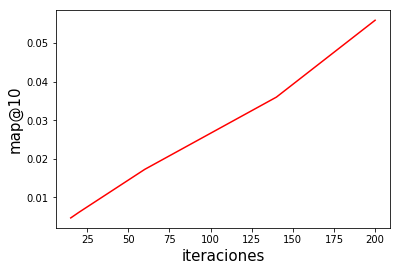

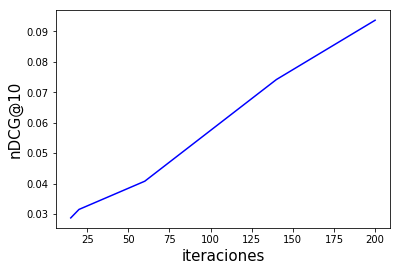

In [36]:
def graph_bpr_test_iterations():
    maprec_results = []
    ndcg_results = []
    for i in test_iterations:
        my_time = time.time()
        model_bpr = implicit.bpr.BayesianPersonalizedRanking(iterations=i)
        model_bpr.fit(matrix)
        maprec, ndcg = evaluate_model(model_bpr, n=10)
        maprec_results.append(maprec)
        ndcg_results.append(ndcg)
        recommendations = show_recommendations(model_bpr, 0, 5)
        print("recomendaciones: ", i,":", recommendations)
        my_time = time.time() - my_time
        print("timepo: ",i,":", my_time)

    plt.plot(test_iterations, maprec_results, 'r-')
    plt.xlabel('iteraciones', fontsize=15)
    plt.ylabel('map@10', fontsize=15)
    plt.show()

    plt.plot(test_iterations, ndcg_results, 'b-')
    plt.xlabel('iteraciones', fontsize=15)
    plt.ylabel('nDCG@10', fontsize=15)
    plt.show()

graph_bpr_test_iterations()



recomendaciones:  0.01 : [200601018, 200603097, 200602011, 200604009, 200605074]
tiempo:  0.01 : 10.360525131225586



recomendaciones:  0.1 : [200505032, 200510005, 200606016, 200603059, 200507098]
tiempo:  0.1 : 11.269201040267944



recomendaciones:  0.15 : [200512069, 200509027, 200505058, 200606044, 200602006]
tiempo:  0.15 : 8.748910427093506



recomendaciones:  0.2 : [200904074, 200710225, 200710042, 200706029, 200802057]
tiempo:  0.2 : 9.31093430519104



recomendaciones:  0.5 : [201403163, 201706170, 200902122, 201703034, 201710152]
tiempo:  0.5 : 9.803916692733765


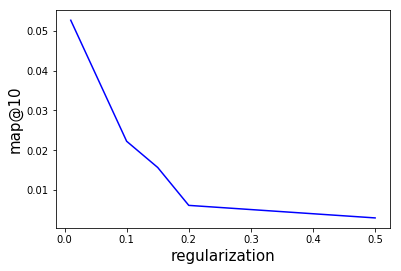

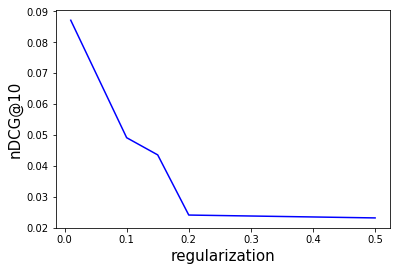

In [38]:
def graph_bpr_test_regulazation():
    maprec_results = []
    ndcg_results = []
    for r in test_regulazation:
        my_time = time.time()
        model_bpr = implicit.bpr.BayesianPersonalizedRanking(regularization=r)
        model_bpr.fit(matrix)
        model_bpr.fit(matrix)
        maprec, ndcg = evaluate_model(model_bpr, n=10)
        maprec_results.append(maprec)
        ndcg_results.append(ndcg)
        recommendations = show_recommendations(model_bpr, 0, 5)
        print("recomendaciones: ", r,":", recommendations)
        my_time = time.time() - my_time
        print("tiempo: ",r,":", my_time)

    plt.plot(test_regulazation, maprec_results, 'b-')
    plt.xlabel('regularization', fontsize=15)
    plt.ylabel('map@10', fontsize=15)
    plt.show()

    plt.plot(test_regulazation, ndcg_results, 'b-')
    plt.xlabel('regularization', fontsize=15)
    plt.ylabel('nDCG@10', fontsize=15)
    plt.show()

graph_bpr_test_regulazation()


recomendaciones:  0.001 : [201706187, 201602160, 201505145, 201506127, 201507005]
tiempo:  0.001 : 6.050525188446045



recomendaciones:  0.01 : [200505072, 200508079, 200604008, 200602005, 200702002]
tiempo:  0.01 : 5.9716949462890625



recomendaciones:  0.02 : [200602026, 200508010, 200508079, 200511003, 200505090]
tiempo:  0.02 : 6.617535352706909



recomendaciones:  0.05 : [200507005, 200602003, 200510063, 200602049, 200509009]
tiempo:  0.05 : 6.383356332778931


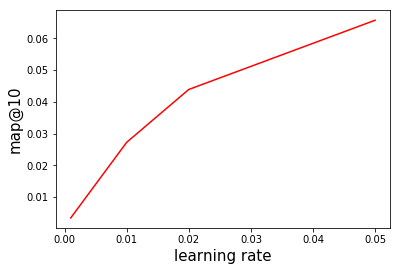

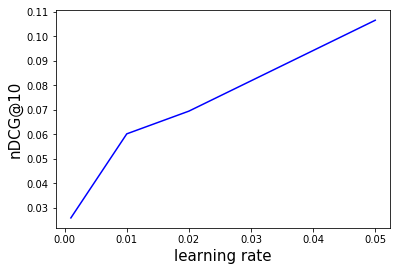

In [40]:
def graph_bpr_test_lr():
    maprec_results = []
    ndcg_results = []
    for l in test_lr:
        my_time = time.time()

        model_bpr = implicit.bpr.BayesianPersonalizedRanking(learning_rate=l)

        model_bpr.fit(matrix)
        maprec, ndcg = evaluate_model(model_bpr, n=10)
        maprec_results.append(maprec)
        ndcg_results.append(ndcg)
        recommendations = show_recommendations(model_bpr, 0, 5)
        print("recomendaciones: ", l,":", recommendations)
        my_time = time.time() - my_time
        print("tiempo: ",l,":", my_time)

    plt.plot(test_lr, maprec_results, 'r-')
    plt.xlabel('learning rate', fontsize=15)
    plt.ylabel('map@10', fontsize=15)
    plt.show()

    plt.plot(test_lr, ndcg_results, 'b-')
    plt.xlabel('learning rate', fontsize=15)
    plt.ylabel('nDCG@10', fontsize=15)
    plt.show()
    
graph_bpr_test_lr()

 

## 2.3 Comparacion de los modelos con los mejores hiperparámetros


Como se observa en los gráficos los mejores hiperparámetros para los modelos son:


Para ALS: factor de 50, 140 iteraciones y regularizador de 0.15

Para BPR: factor de 150, 15 iteraciones, regularizador de 0.15 y learning rate de 0.01

Ver tabla en el informe pdf

In [48]:
def compare_best_models():
    model_als = implicit.als.AlternatingLeastSquares(
                            factors=50,
                            iterations = 140,
                            regularization=0.15)

    model_als.fit(matrix)
    maprec, ndcg = evaluate_model(model_als, n=10)
    print("ALS maprec y ndcg",maprec, ndcg)

    model_bpr = implicit.bpr.BayesianPersonalizedRanking(
                            factors=150,
                            iterations = 15,
                            regularization=0.15,
                            learning_rate=0.01)
    model_bpr.fit(matrix)
    maprec, ndcg = evaluate_model(model_bpr, n=10)
    print("BPR maprec y ndcg",maprec, ndcg)

compare_best_models()


ALS maprec y ndcg 0.04704175864131897 0.08063021316033364



BPR maprec y ndcg 0.003413975344025218 0.026876737720111215


In [43]:
def write_recommendations_best_model():
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(
                            factors=150,
                            iterations = 15,
                            regularization=0.5,
                            learning_rate=0.01)
    model_bpr.fit(matrix)

    fo = open("files/test.csv", "r")
    fw = open("results.json", "w+")
    fw.write("{\n")
    fo.readline()
    for u in fo.readlines():
        u = int(u.strip())
        nu = user_ids[u]
        recommendations = show_recommendations(model=model_bpr, user=nu, n=10)
        fw.write('"'+str(u)+'"'+": ")
        fw.write(str(recommendations) + "," + "\n")

    fw.write("}\n")
    fw.close()
    fo.close()

Las recomendaciones por usuario se encuentran en el archivo json results.json

# Pregunta 3 Recomendacion basada en contenido

Recordemos que Tf-idf es una medida numérica que expresa cuán relevante es una palabra para un documento en una colección. Ahora, dada la frecuencia de cada palabra en cada texto, se v a utilizar esta ténica para obtener tuplas de la forma `(ID, Tf-idf)` en donde ID será el ID de la palabra igual como estaba antes (por ejemplo **"a"** tiene ID 30) y Tf-Idf será el valor dado por este algoritmo a la palabra en cuestión.

In [0]:
tfidf_model_file = 'resources/tfidf_model.p'

if isfile(tfidf_model_file):
    tfidf_model = models.tfidfmodel.TfidfModel().load(tfidf_model_file)

else:
    tfidf_model = models.tfidfmodel.TfidfModel(corpus, dictionary=dictionary)
    tfidf_model.save(tfidf_model_file)

corpus_df['tf_idf'] = tfidf_model[corpus_df.bow.tolist()]
corpus_df.head(5)

## Generar recomendaciones: 
En esta sección se implementan las funciones necesarias para poder generar recomendaciones dado lo que un usuario ha consumido. De manera artificial, se "samplearán" 3 documentos aleatorios que representarán al usuario objetivo (`sample`). Luego tendrás que generar diferentes recomendaciones y evaluar los resultados.

In [0]:
# Random users
samples = corpus_df.sample(3)
samples_ids = []

for n, (ix, paper) in enumerate(samples.iterrows()):
    samples_ids.append(ix)
    idx, title, abstract, bow, tf_idf = paper[[
        'id', 'title', 'abstract', 'bow', 'tf_idf']]
    print('%d) %s' % (n+1, title))
    print('')
    print("\n".join(wrap(abstract)))
    print('\n')

Lo anterior son 3 textos tomados al azar. Asumiremso que una persona vió estos 3 textos y ahora vamos a recomendarle 5 nuevos por cada documento.

In [0]:
# Recommendation functions

N = len(dictionary)


def to_sparse(matrix):
    return csr_matrix([
        gensim.matutils.sparse2full(row, length=N)
        for row in matrix
    ])


def make_recommendations(model, metric, neighbors):
    M = len(corpus)

    X = to_sparse(corpus_df[model].tolist())
    document_index = NearestNeighbors(
        n_neighbors=(neighbors + 1),
        algorithm='brute',
        metric=metric).fit(X)
    return document_index


def print_recommendations(indexes, model):
    for n, (ix, paper) in enumerate(samples.iterrows()):
        dists, neighbors = indexes.kneighbors([gensim.matutils.sparse2full(paper[model], length=N)])
        print(paper['title'])
        print('')
        print('Documentos cercanos: ')
        i = 1
        for neighbour in neighbors[0]:
            if ix != neighbour:
                line = str(i) + ". " + corpus_df.iloc[neighbour]['title']
                print(line)
                i += 1
        print('\n')

A continuación deberá utilizar las funciones implementadas anteriormente para generar nuevas recomendaciones variando los parámetros del modelo. **Agregue nuevas celdas para cada implementación y/o pregunta.**

In [0]:
# Recommendation example: TF-IDF
doc_idx = make_recommendations('tf_idf', 'euclidean', 5)
print_recommendations(doc_idx, 'tf_idf')

# Stop words

A continuación, intentaremos mejorar los resultados obtenidos con TF-IDF eliminando las *stopwords*. ¿Qué son las *stopwords*? Son palabras vacías, sin significado, que no aportan (de manera significativa) al sentido de una frase, como los artículos, pronombres, etc.

In [0]:
nltk.download('stopwords')

In [0]:
from nltk.corpus import stopwords

def remove_stopwords(text):
    filtered_words = [
        word for word in text if word not in stopwords.words('english')
    ]
    return filtered_words

Ahora eliminamos los stopwords de los textos y volvemos a hacer todo el proceso pero con textos diferentes. Este proceso dura aproximadamente **5 minutos**

In [0]:
%%time
# Puede que se demore un poco esta celda
corpus_df['tokenized_abstract_without_stopwords'] = corpus_df.tokenized_abstract.map(remove_stopwords)

In [0]:
corpus_df.head(5)

In [0]:
corpus_df['bow_without_stopwords'] = corpus_df.tokenized_abstract_without_stopwords.map(dictionary.doc2bow)
corpus_df.head(5)

In [0]:
corpus = corpus_df['bow_without_stopwords'].tolist()

tfidf_model_file_without_stopwords = 'resources/tfidf_model.p'

if isfile(tfidf_model_file):
    tfidf_model_without_stopwords = models.tfidfmodel.TfidfModel().load(tfidf_model_file)

else:
    tfidf_model_without_stopwords = models.tfidfmodel.TfidfModel(corpus, dictionary=dictionary)
    tfidf_model_without_stopwords.save(tfidf_model_file_without_stopwords)

corpus_df['tf_idf_without_stopwords'] = tfidf_model_without_stopwords[corpus_df.bow_without_stopwords.tolist()]
corpus_df.head(5)

**Actividad:** Genere recomendaciones para un nuevo usuario utilizando los nuevos vectores generados sin stop-words.

# Word Embeddings
En esta sección haremos recomendacion de textos médicos de [PubMed](https://www.ncbi.nlm.nih.gov/pubmed/) que han sido revisados por expertos. 

RESPONDER LAS SIGUIENTES PREGUNTAS: 
- ¿Que son word embeddings? ¿Cuál es la intuición?
- ¿Por qué son útiles para representar documentos?


In [0]:
# Descarga de recursos
!wget https://www.dropbox.com/s/gc3x9rp4gu2tmch/documents_w2vec.json.zip
!unzip documents_w2vec.json.zip

In [0]:
# Descarga del dataset
!wget https://www.dropbox.com/s/1bxuw3uf3xwyrr7/pubmed_data.csv

Podemos ver que este _dataet: contiene 4 columnas:
* **user_id**: identificador de cada usuario 
* **pid**: identificador de cada texto con su correlativo de PubMed. 
* **_title_**: título del documento, en este caso, de un _paper_
* **_abstract_**: primer párafo del _paper_ que es una representación abreviada, objetiva y precisa del contenido de un documento o recurso.

In [0]:
df = pd.read_csv('pubmed_data.csv')
df.head()

In [0]:
# creamos diccionario de titulos y abstracts que utilizaremos despues
dict_title_abstract = {}

for pid, title, abstract in zip(df.pid, df.title, df.abstract):
  dict_title_abstract[pid] = {'title': title, 'abstract': abstract}

In [0]:
# cargamos diccionario de embeddings por cada documento (pre-procesado)
w2vec_vectors = json.load(open('documents_w2vec.json'))


creamos un objeto *gensim.keyedvectors* para hacer más eficiente la búsqueda de documentos similares

In [0]:
embedding_size = 300

doc2vec = gensim.models.keyedvectors.Word2VecKeyedVectors(embedding_size)
keys = list(w2vec_vectors.keys())
values = [
    w2vec_vectors[key]
    for key in keys
]
doc2vec.add(keys, values)

## Generar recomendaciones

función **find_similar** para encontrar documentos similares a un pid en particular que recibe id del documento y los topn documentos mas similares y retorna topn documentos más similares

In [0]:
def find_similar(pid, topn):
  results = []

  for id_, score in doc2vec.similar_by_vector(doc2vec[pid], topn=topn):
      results.append([id_, score, dict_title_abstract[int(id_)]['title'], dict_title_abstract[int(id_)]['abstract']])

  return pd.DataFrame(results[1:], columns = ['pid', 'score', 'title', 'abstract'])

In [0]:
find_similar('22508578', 10)

función **recommend** para recomendar a un usuario de acuerdo una muestra de documentos que ha leído.

In [0]:
def recommend(user_id, topn, sample_user):
  user_docs =  df[df.user_id==user_id]['pid'].sample(sample_user)

  results = []

  for pid in user_docs:

    for id_, score in doc2vec.similar_by_vector(doc2vec[str(pid)], topn=topn):

      if int(id_) in dict_title_abstract:
        results.append([id_, score, dict_title_abstract[int(id_)]['title'], dict_title_abstract[int(id_)]['abstract']])
    

  results = sorted(results, key = lambda x: int(x[1]))

  return pd.DataFrame(results[topn:], columns = ['pid', 'score', 'title', 'abstract']).head(10)

In [0]:
# documentos leidos por el usuario 
df[df.user_id==348892].sample(10)

In [0]:
recommend(user_id= 348892, topn= 10, sample_user = 5)

RESPONDER:
- ¿Qué problemas puede tener la recomendación basada en contenido?